
# Diabetes Prediction - Simplified Analysis

## Data Dictionary

| Column | Description |
|---|---|
| Pregnancies | Number of times pregnant |
| Glucose | Plasma glucose concentration (2 hours in an oral glucose tolerance test) |
| BloodPressure | Diastolic blood pressure (mm Hg) |
| SkinThickness | Triceps skin fold thickness (mm) |
| Insulin | 2-Hour serum insulin (mu U/ml) |
| BMI | Body mass index (weight in kg/(height in m)^2) |
| DiabetesPedigreeFunction | A function that scores likelihood of diabetes based on family history |
| Age | Age in years |
| Outcome | Class variable (0 or 1), 1 means diabetic |



## 1. Import Libraries and Load Data

**What we do here:**
- Import the essential libraries.
- Load `diabetes.csv` (`../data/raw/diabetes.csv` by default).
- Show the first few rows to confirm the schema.


In [21]:

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
)
from joblib import dump

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", None)

csv_path = "../data/raw/diabetes.csv"

df = pd.read_csv(csv_path)
print("Loaded:", csv_path)

print("Shape:", df.shape)
print("Columns:", list(df.columns))
display(df.head())


Loaded: ../data/raw/diabetes.csv
Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



## 2. Data Understanding and Exploration

**Checklist:**
- Inspect data types, missing values, and basic statistics.
- Check class balance for the target (`Outcome`).


In [31]:
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
df.columns
for col in df.columns:
    zero=(df[col]==0).sum()
    print( f"Missing Values per column:'{col}':{zero}")

# outcome count per class sorted
class_counts = df['Outcome'].value_counts().sort_index()
class_percentage = (class_counts / len(df) * 100).round(2)
print("\nClass Distribution (counts):\n", class_counts)
print("\nClass Distribution (percent):\n", class_percentage)
df.describe()


Shape: (768, 9)

Dtypes:
 Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
Missing Values per column:'Pregnancies':111
Missing Values per column:'Glucose':5
Missing Values per column:'BloodPressure':35
Missing Values per column:'SkinThickness':227
Missing Values per column:'Insulin':374
Missing Values per column:'BMI':11
Missing Values per column:'DiabetesPedigreeFunction':0
Missing Values per column:'Age':0
Missing Values per column:'Outcome':500

Class Distribution (counts):
 Outcome
0    500
1    268
Name: count, dtype: int64

Class Distribution (percent):
 Outcome
0    65.1
1    34.9
Name: count, dtype: float64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



## 3. Data Cleaning and Preprocessing

**Context:** This dataset encodes missing measurements as `0` for some physiological features. We will:
1. Replace zeros with `NaN` in: `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`.
2. Impute missing values with **median**.
3. Save a cleaned copy in `../data/processed/diabetes_clean.csv`.


In [23]:

df_clean = df.copy()
zero_as_nan = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]

print("Zero counts BEFORE:")
display((df_clean[zero_as_nan] == 0).sum())

# Replace zeros with NaN
df_clean[zero_as_nan] = df_clean[zero_as_nan].replace(0, np.nan)

print("\nMissing after zero->NaN:")
display(df_clean[zero_as_nan].isna().sum())

# Median imputation
df_clean[zero_as_nan] = df_clean[zero_as_nan].fillna(df_clean[zero_as_nan].median())

print("\nMissing AFTER imputation (should be 0):")
display(df_clean[zero_as_nan].isna().sum())

# Save processed
os.makedirs("../data/processed", exist_ok=True)
processed_path = "../data/processed/diabetes_clean.csv"
df_clean.to_csv(processed_path, index=False)
print("\nSaved cleaned data to:", processed_path)


Zero counts BEFORE:


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


Missing after zero->NaN:


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


Missing AFTER imputation (should be 0):


Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


Saved cleaned data to: ../data/processed/diabetes_clean.csv



## 4. Exploratory Data Analysis (EDA)

**Visual checks:**
- Class distribution plot.
- Correlation heatmap.
- Distributions by Outcome for key features.



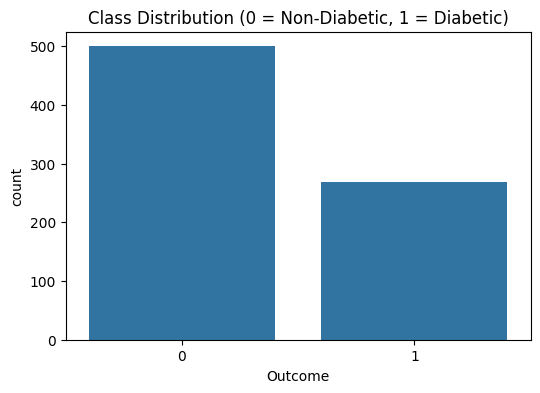

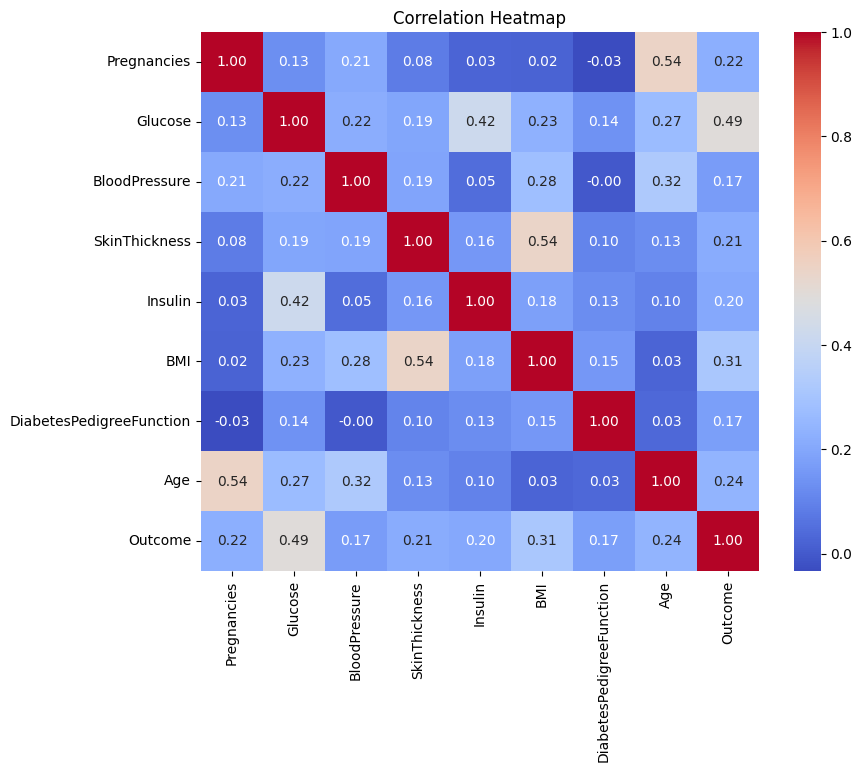

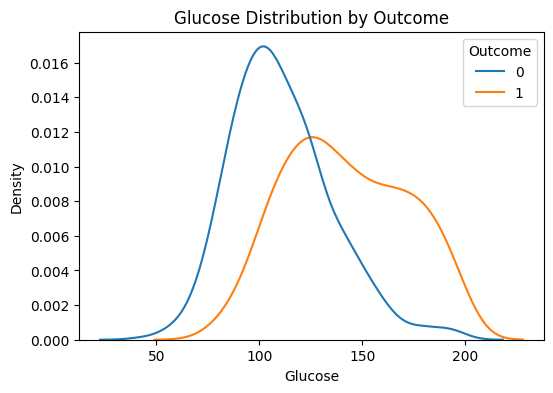

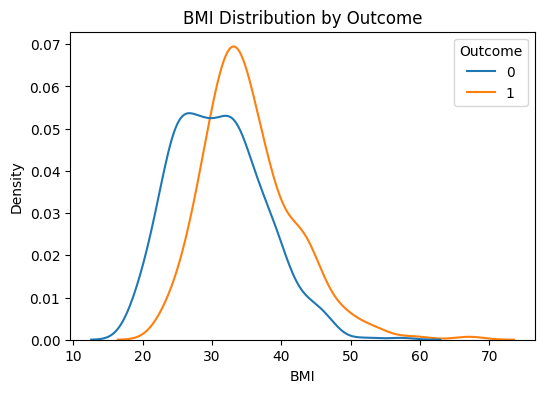

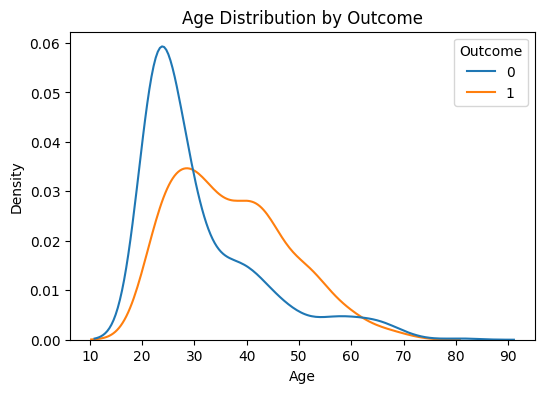

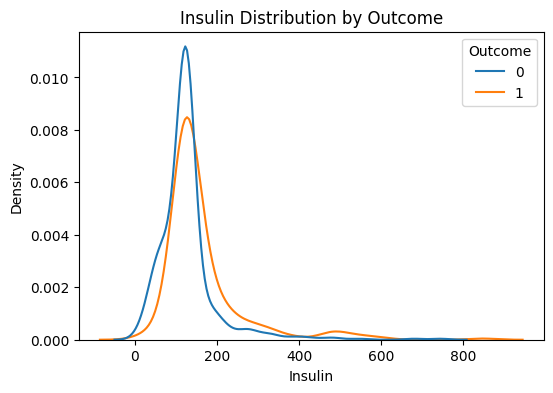

In [24]:

plt.figure(figsize=(6,4))
sns.countplot(x='Outcome', data=df_clean)
plt.title("Class Distribution (0 = Non-Diabetic, 1 = Diabetic)")
plt.show()

plt.figure(figsize=(9,7))
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

for col in ["Glucose","BMI","Age","Insulin"]:
    if col in df_clean.columns:
        plt.figure(figsize=(6,4))
        sns.kdeplot(data=df_clean, x=col, hue="Outcome", common_norm=False)
        plt.title(f"{col} Distribution by Outcome")
        plt.show()



## 5. Data Preparation for Machine Learning

**Steps:**
- Split data into Train/Test (80/20, stratified).
- Scale features with `StandardScaler` (fit on train, transform train & test).


In [25]:

X = df_clean.drop(columns=["Outcome"])
y = df_clean["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("X_train shape:", X_train.shape, " | X_test shape:", X_test.shape)
print("y_train mean:", y_train.mean().round(3), " | y_test mean:", y_test.mean().round(3))


X_train shape: (614, 8)  | X_test shape: (154, 8)
y_train mean: 0.349  | y_test mean: 0.351



## 6. Model Building and Evaluation

We’ll compare two baseline models:

1. **Logistic Regression** (interpretable linear baseline).
2. **Random Forest** (non-linear ensemble).

**Metrics reported:**
- Classification report: Precision, Recall, F1 for each class.
- ROC AUC.
- Confusion Matrix, ROC Curve, Precision-Recall Curve.

In [26]:

models = {
    "LogisticRegression": LogisticRegression(max_iter=500, class_weight="balanced", random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE),
}

results = {}

for name, model in models.items():
    if name == "LogisticRegression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 3))
    print()
    
    results[name] = {"model": model, "y_pred": y_pred, "y_prob": y_prob}


=== LogisticRegression ===
              precision    recall  f1-score   support

           0      0.824     0.750     0.785       100
           1      0.603     0.704     0.650        54

    accuracy                          0.734       154
   macro avg      0.714     0.727     0.717       154
weighted avg      0.747     0.734     0.738       154

ROC AUC: 0.813

=== RandomForest ===
              precision    recall  f1-score   support

           0      0.780     0.850     0.813       100
           1      0.667     0.556     0.606        54

    accuracy                          0.747       154
   macro avg      0.723     0.703     0.710       154
weighted avg      0.740     0.747     0.741       154

ROC AUC: 0.816



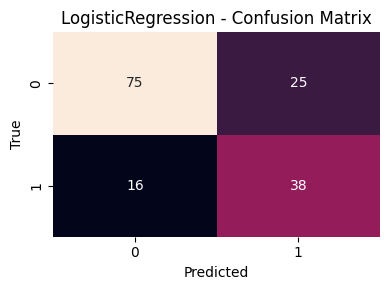

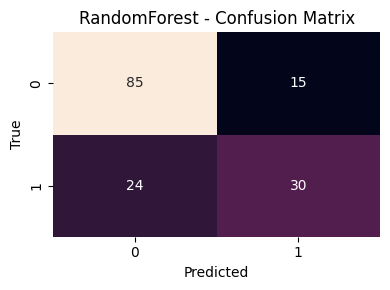

In [27]:

# Confusion Matrices
for name, out in results.items():
    cm = confusion_matrix(y_test, out["y_pred"])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.show()


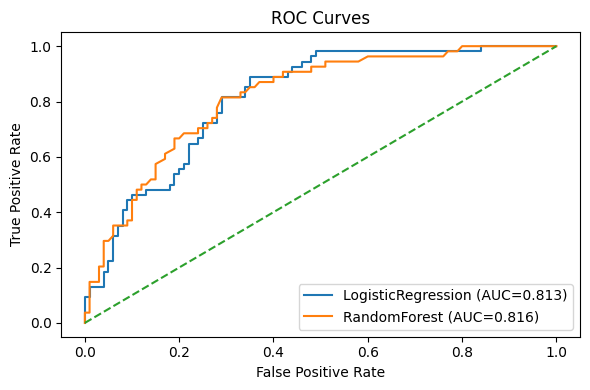

In [28]:

# ROC Curves
plt.figure(figsize=(6,4))
for name, out in results.items():
    fpr, tpr, _ = roc_curve(y_test, out["y_prob"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.tight_layout()
plt.show()


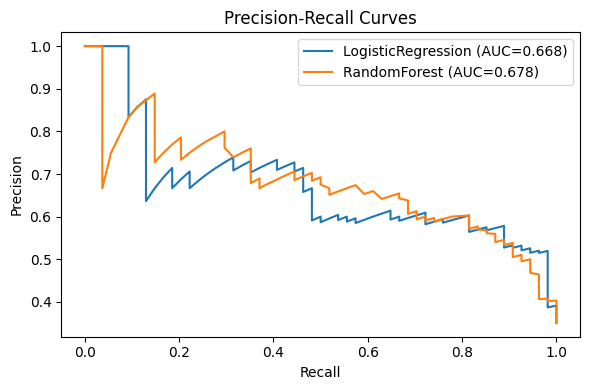

In [29]:

# Precision-Recall Curves
plt.figure(figsize=(6,4))
for name, out in results.items():
    precision, recall, _ = precision_recall_curve(y_test, out["y_prob"])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC={pr_auc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.tight_layout()
plt.show()



### 7. Understanding the Machine Learning Models

- **Logistic Regression:** Estimates probability of the positive class using a linear combination of features passed through a sigmoid. Interpretable coefficients; benefits from scaled features.

- **Random Forest:** Ensemble of decision trees with bootstrap aggregation and feature randomness. Captures non-linearities and interactions; robust to outliers; provides feature importances.



## 8. Clinical Insights and Recommendations

- **Prioritize Recall (Sensitivity):** In screening, missing a diabetic (false negative) is more harmful than flagging a non-diabetic (false positive). Consider adjusting the decision threshold to increase recall.
- **Key Drivers:** Glucose and BMI typically show strong associations; Age and Insulin can also contribute.
- **Next Steps:** Cross-validation, model calibration (e.g., Platt or isotonic), explore additional models (XGBoost/LightGBM), and external validation on a different cohort.



## 9. Project Summary

**What we did:**
- Loaded the Pima Indians Diabetes dataset.
- Cleaned and imputed physiologically implausible zeros.
- Performed EDA and visualized key patterns.
- Split data, scaled features, and trained baseline models.
- Evaluated with classification metrics, ROC/PR curves.
- Discussed clinical implications and next steps.

**Artifacts Saved:**
- Cleaned data: `../data/processed/diabetes_clean.csv`  
- (Run the cell below to save the trained scaler and chosen model.)


In [30]:

# Choose which model to persist (adjust as needed)
chosen = "RandomForest" if "RandomForest" in results else list(results.keys())[0]
model_to_save = results[chosen]["model"]

os.makedirs("../models", exist_ok=True)
dump(model_to_save, "../models/model.joblib")
dump(scaler, "../models/scaler.joblib")

print("Saved ../models/model.joblib and ../models/scaler.joblib (model:", chosen, ")")


Saved ../models/model.joblib and ../models/scaler.joblib (model: RandomForest )
